# Import Library

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets,layers,optimizers,Sequential,metrics

# Load Data

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_path = "gdrive/MyDrive/Morrison Pouch/four class train"
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path, labels='inferred', label_mode='int',class_names=None,
    color_mode='rgb', batch_size=64, image_size=(400, 400), shuffle=True,
    seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False)

Found 10794 files belonging to 4 classes.


In [ ]:
val_path = "gdrive/MyDrive/Morrison Pouch/four class validation"
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_path, labels='inferred', label_mode='int',class_names=None,
    color_mode='rgb', batch_size=64, image_size=(400, 400), shuffle=True,
    seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False)

Found 6118 files belonging to 4 classes.


In [ ]:
class_names = train_data.class_names

class_names

['NH', 'NL', 'PH', 'PL']

# data preprocessing

In [ ]:
input_shape = (400, 400, 3)
# preprocess_input = tf.keras.applications.ResNet50V2.preprocess_input
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=input_shape),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.4),])

# Create the base model from the pre-trained model ResNet50 V2

In [ ]:
base_model = tf.keras.applications.ResNet50V2(
    include_top= False,
    weights="imagenet",
    input_shape=input_shape
)

94674944/94668760 [==============================] - 1s 0us/step


# fine tuning feature extraction layers

In [ ]:
base_model.trainable = True  #set weights to be trainable

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 96

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Let's take a look at the base model architecture
# base_model.summary()

Number of layers in the base model:  190


# add FCN layer

In [ ]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

batchnorm = tf.keras.layers.BatchNormalization()

prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 13, 13, 2048)
(64, 2048)
(64, 4)


# compile the model

In [ ]:
inputs = tf.keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = batchnorm(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.000002  #set learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print (model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 400, 400, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 13, 13, 2048)      23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196  

# check initial loss/acc before training

In [ ]:
loss0, accuracy0 = model.evaluate(val_data)
print("initial loss: {:.3f}".format(loss0))
print("initial accuracy: {:.3f}".format(accuracy0))

# Save the best weights

In [ ]:
checkpoint_filepath = 'gdrive/MyDrive/morrison_4class_weights_ResNet50V2_96.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_best_only=True, monitor='val_accuracy',
    mode='auto', verbose=1)

# training process

In [ ]:
epochs = 100

class_weight = {0: 1, 1: 1, 2: 10, 3: 10}  #set class weight to reward ascites detection

# Model weights are saved at the end of every epoch, if it's the best seen so far.
history = model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[model_checkpoint_callback], class_weight=class_weight)

Epoch 1/100
128/128 [==============================] - 3567s 28s/step - loss: 10.8706 - accuracy: 0.2757 - val_loss: 1.5128 - val_accuracy: 0.1829

Epoch 00001: val_accuracy improved from -inf to 0.18293, saving model to gdrive/MyDrive/morrison_4class_weights_0223.hdf5
Epoch 2/100
128/128 [==============================] - 191s 1s/step - loss: 8.8889 - accuracy: 0.3541 - val_loss: 1.3424 - val_accuracy: 0.3260

Epoch 00002: val_accuracy improved from 0.18293 to 0.32597, saving model to gdrive/MyDrive/morrison_4class_weights_0223.hdf5
Epoch 3/100
128/128 [==============================] - 191s 1s/step - loss: 7.5586 - accuracy: 0.4191 - val_loss: 1.1905 - val_accuracy: 0.4522

Epoch 00003: val_accuracy improved from 0.32597 to 0.45221, saving model to gdrive/MyDrive/morrison_4class_weights_0223.hdf5
Epoch 4/100
128/128 [==============================] - 190s 1s/step - loss: 7.0730 - accuracy: 0.4456 - val_loss: 1.0719 - val_accuracy: 0.5405

Epoch 00004: val_accuracy improved from 0.452

# plot loss and accuray of training

In [ ]:
%matplotlib inline

Text(0.5, 0, 'epoch')

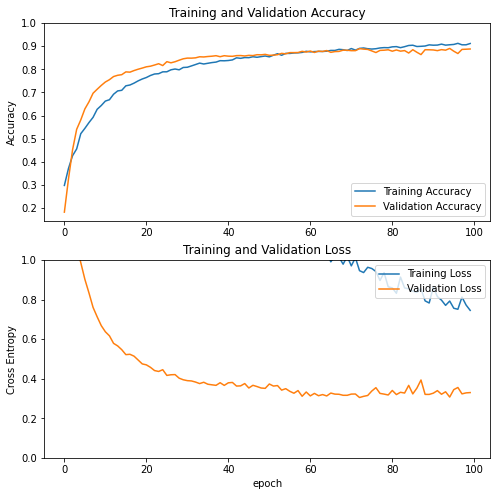

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

In [ ]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

#visualize validation result

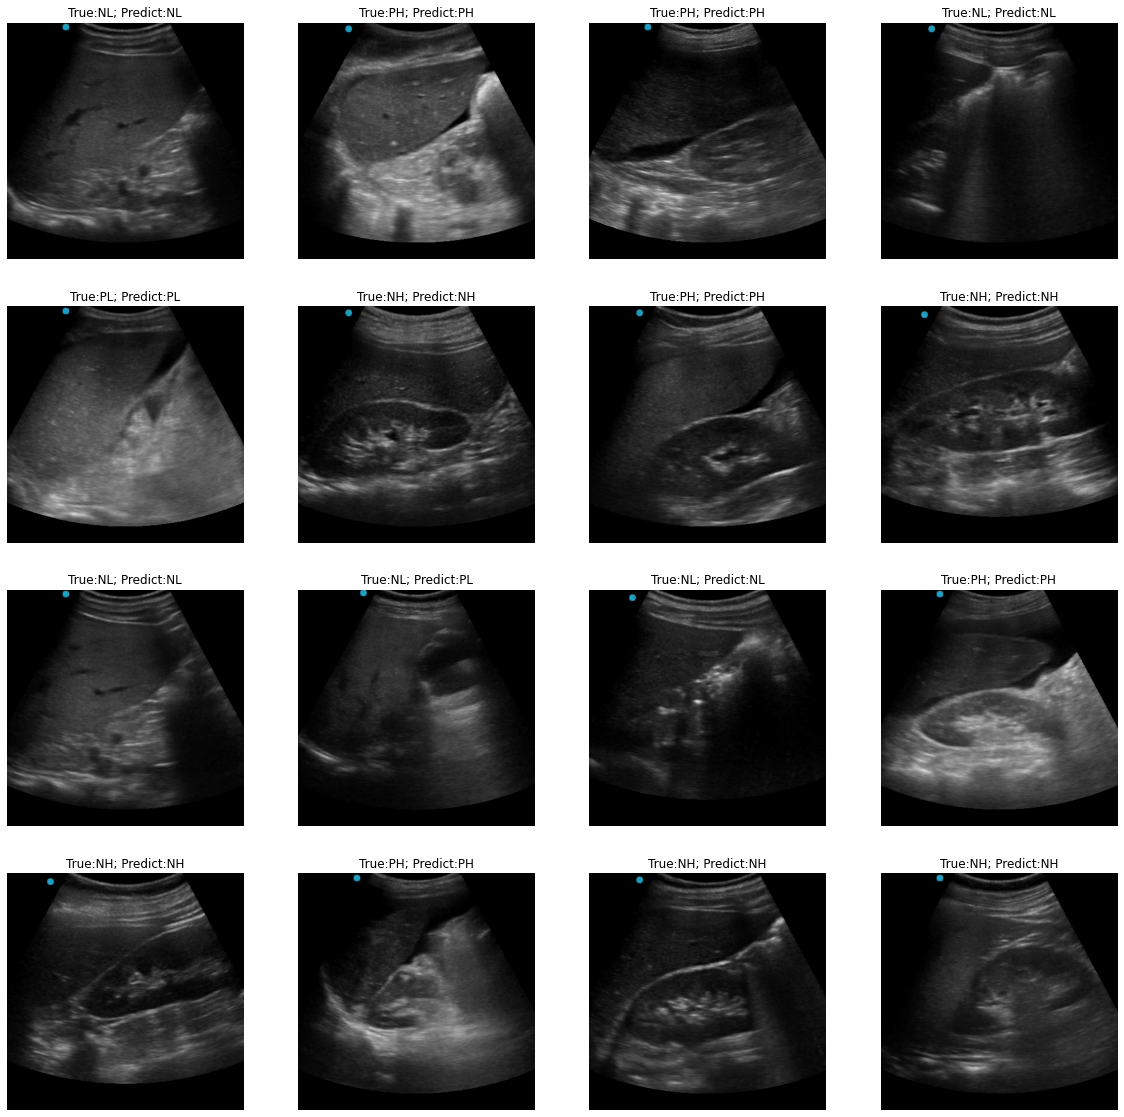

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in val_data.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    img_array = tf.expand_dims(images[i], 0) #throw in an img_array
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0]) #output single image prediction result
    plt.title("True:{}; Predict:{}".format(class_names[labels[i]], class_names[np.argmax(score)]))
    plt.axis("off")

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in val_data:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
  labels = np.concatenate([labels, y.numpy()])

tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

array([[1719,  115,   41,    0],
       [  62, 1070,   14,   50],
       [  73,    5, 1637,  114],
       [   8,   10,  176,  974]], dtype=int32)

#plot test images

In [ ]:
test_path = "gdrive/MyDrive/Morrison Pouch/Morrison Test/Test positive 2021 S"
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_path, labels='inferred', label_mode='int',class_names=None,
    color_mode='rgb', batch_size=64, image_size=(400, 400), shuffle=True,
    seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False)

Found 173 files belonging to 4 classes.


In [ ]:
test_class = test_data.class_names

test_class

['NH', 'NL', 'PH', 'PL']

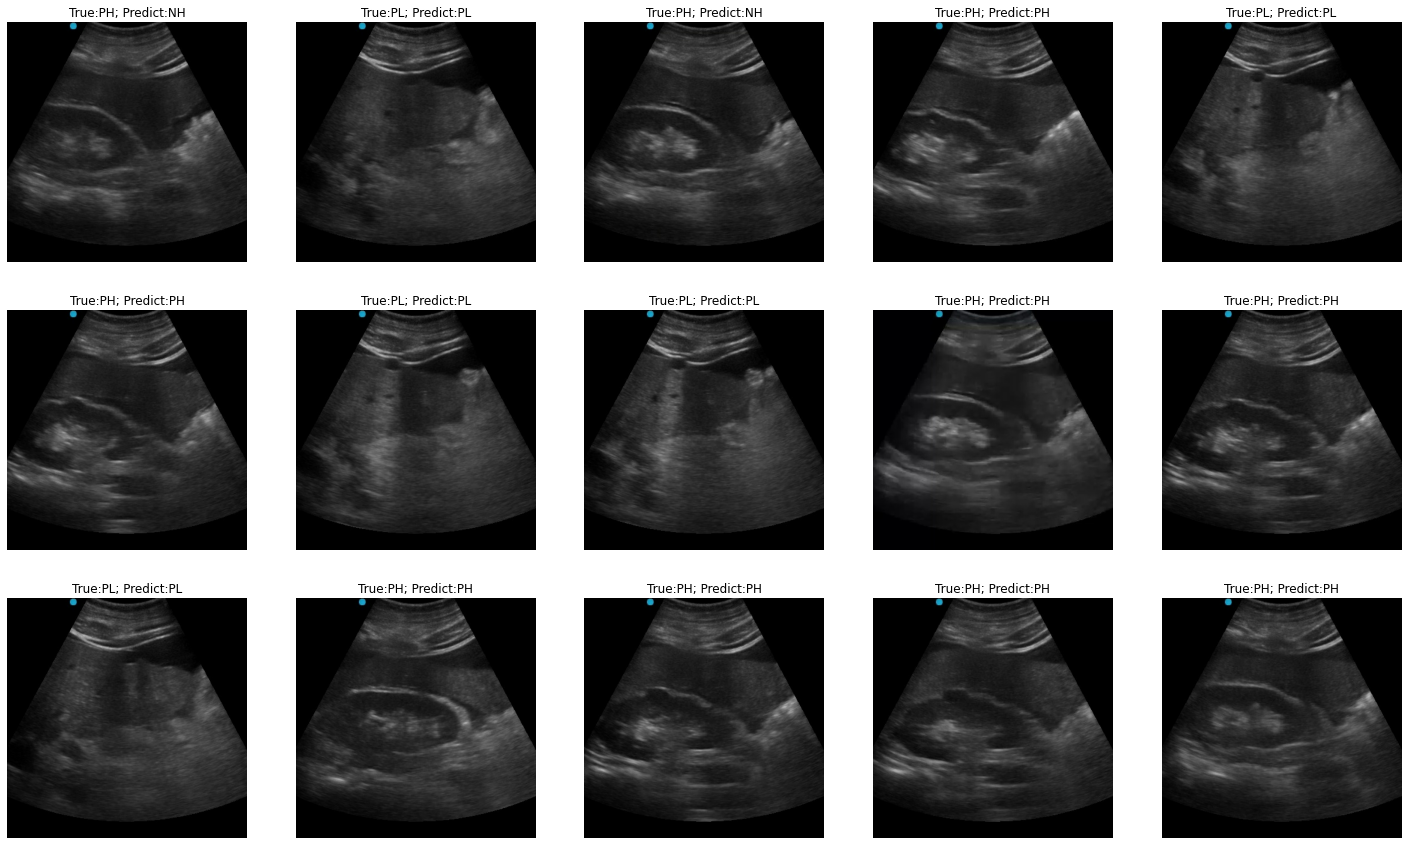

In [ ]:
plt.figure(figsize=(25, 15))
for images, labels in test_data.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    img_array = tf.expand_dims(images[i], 0) #throw in an img_array
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0]) #output single image prediction result
    plt.title("True:{}; Predict:{}".format(class_names[labels[i]], class_names[np.argmax(score)]))
    plt.axis("off")

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_data:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
  labels = np.concatenate([labels, y.numpy()])

tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [24,  0, 76,  1],
       [ 0,  0,  0, 72]], dtype=int32)